Dataset: http://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes

Replace zeros = NaN in some columns by median, mean, most frequent or some other custom value  
--> no benefit from that

**Feature Selection:**  
Principal Component Analysis (PCA)  
Recursive Feature Elimination (RFE)  
Feature Importance (e.g. by Gradient Boosting)

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA, NMF
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, RFECV
from sklearn.preprocessing import Imputer
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv('pima-indians-diabetes.data', header=None,
                 names=['preg', 'gluc', 'blood_p', 'skin', 'insu', 'bmi', 'pedi', 'age', 'class'])
df.head()

,preg,gluc,blood_p,skin,insu,bmi,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
df.describe()

,preg,gluc,blood_p,skin,insu,bmi,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
bins = range(10, 60, 6)
df['bmi_bin'] = pd.cut(df['bmi'], bins, labels=bins[:-1])
df.head()

,preg,gluc,blood_p,skin,insu,bmi,pedi,age,class,bmi_bin
0,6,148,72,35,0,33.6,0.627,50,1,28
1,1,85,66,29,0,26.6,0.351,31,0,22
2,8,183,64,0,0,23.3,0.672,32,1,22
3,1,89,66,23,94,28.1,0.167,21,0,28
4,0,137,40,35,168,43.1,2.288,33,1,40


In [5]:
grouped = df[['bmi_bin', 'class']].groupby(['bmi_bin'], as_index=False).mean()
grouped['class'] = grouped['class'].fillna(0.0)
df = df.drop('bmi_bin', axis=1)
grouped

,bmi_bin,class
0,10,0.000000
1,16,0.000000
2,22,0.153005
3,28,0.400810
4,34,0.433673
5,40,0.535211
6,46,0.588235
7,52,0.666667


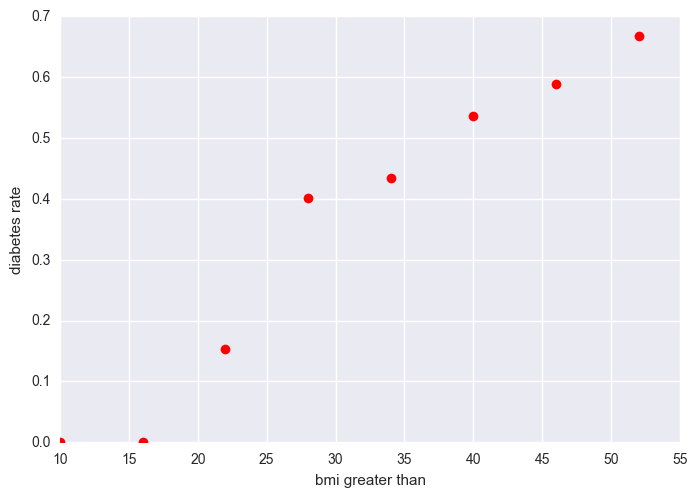

In [6]:
plt.plot(bins[:-1], grouped['class'], 'ro')
plt.xlabel('bmi greater than')
plt.ylabel('diabetes rate')
plt.show()

It's no surprise that overweight and diabetes are positively correlated. There is a huge bump between around 20 and around 30. Probably because there people start be severely overweighted.

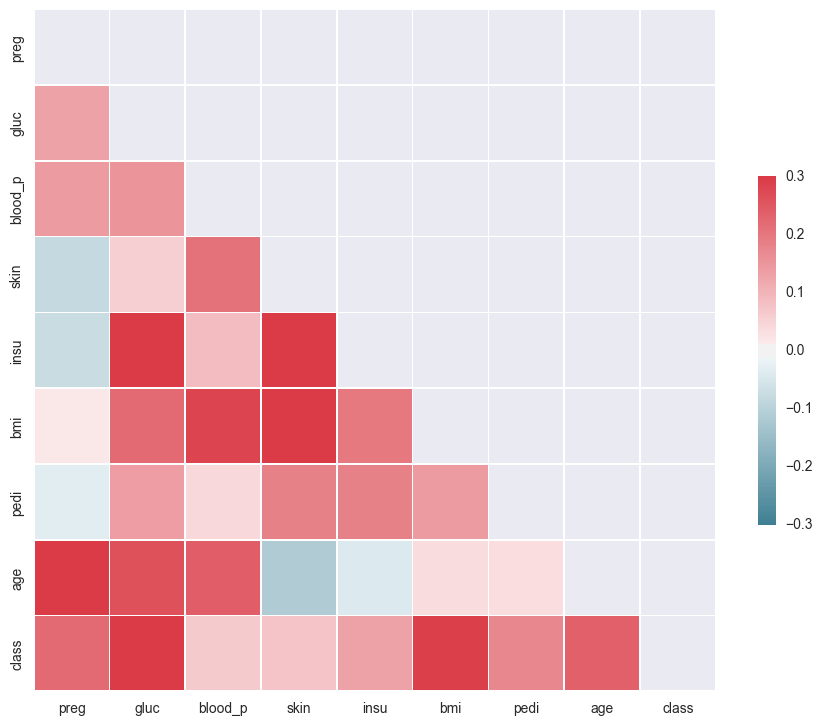

In [7]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [8]:
X, y = df.drop('class', axis=1), df['class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

~~~~
Best parameters set found on development set:

{'C': 1000, 'kernel': 'linear'}

Grid scores on development set:

0.687 (+/-0.047) for {'gamma': 0.001, 'C': 1, 'kernel': 'rbf'}
0.686 (+/-0.067) for {'gamma': 0.0001, 'C': 1, 'kernel': 'rbf'}
0.676 (+/-0.068) for {'gamma': 0.001, 'C': 10, 'kernel': 'rbf'}
0.692 (+/-0.062) for {'gamma': 0.0001, 'C': 10, 'kernel': 'rbf'}
0.634 (+/-0.070) for {'gamma': 0.001, 'C': 100, 'kernel': 'rbf'}
0.702 (+/-0.083) for {'gamma': 0.0001, 'C': 100, 'kernel': 'rbf'}
0.627 (+/-0.061) for {'gamma': 0.001, 'C': 1000, 'kernel': 'rbf'}
0.700 (+/-0.045) for {'gamma': 0.0001, 'C': 1000, 'kernel': 'rbf'}
0.717 (+/-0.067) for {'C': 1, 'kernel': 'linear'}
0.709 (+/-0.064) for {'C': 10, 'kernel': 'linear'}
0.713 (+/-0.060) for {'C': 100, 'kernel': 'linear'}
0.727 (+/-0.092) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.81      0.73      0.77        99
          1       0.58      0.69      0.63        55

avg / total       0.73      0.71      0.72       154
~~~~

Comparing different estimators in one grid search from http://www.codiply.com/blog/hyperparameter-grid-search-across-multiple-models-in-scikit-learn/

I had to make some adaptions to port it to Python 3 (should probably communicate them back to the author)

In [9]:
def grid_results_as_df(grid):
    results = dict()
    results['mean'] = grid.cv_results_['mean_test_score']
    results['std'] = grid.cv_results_['std_test_score']

    for i, params in enumerate(grid.cv_results_['params']):
        for k, v in params.items():
            if k in ['clf']:
                v = str(v)
                v = v[:v.find('(')]
            if not k in results:
                results[k] = [None] * len(results['mean'])
            results[k][i] = v

    return pd.DataFrame.from_dict(results).sort_values('mean', ascending=False)

pipe = Pipeline([
    #('preprocessor', None),
    ('clf', GradientBoostingClassifier(n_estimators=64))
])


N_ESTIMATORS_OPTIONS = [64]
LEARNING_RATE_OPTIONS = [1]

param_grid = [
    {
        #'preprocessor' : [None],
        'clf' : [ExtraTreesClassifier(), RandomForestClassifier(), 
                              AdaBoostClassifier(), GradientBoostingClassifier(), SVC(), KNeighborsClassifier(), GaussianNB()],
        #'clf__n_estimators' : N_ESTIMATORS_OPTIONS,
        #'clf__learning_rate': LEARNING_RATE_OPTIONS
    },
]

grid = GridSearchCV(pipe, cv=10, n_jobs=-1, param_grid=param_grid)
grid.fit(X_train, y_train)

grid_results_as_df(grid)

,clf,mean,std
3,GradientBoostingClassifier,0.771987,0.052102
0,ExtraTreesClassifier,0.747557,0.056105
6,GaussianNB,0.747557,0.048941
2,AdaBoostClassifier,0.741042,0.045389
1,RandomForestClassifier,0.739414,0.042338
5,KNeighborsClassifier,0.724756,0.044497
4,SVC,0.653094,0.004256


Optimal number of features : 7


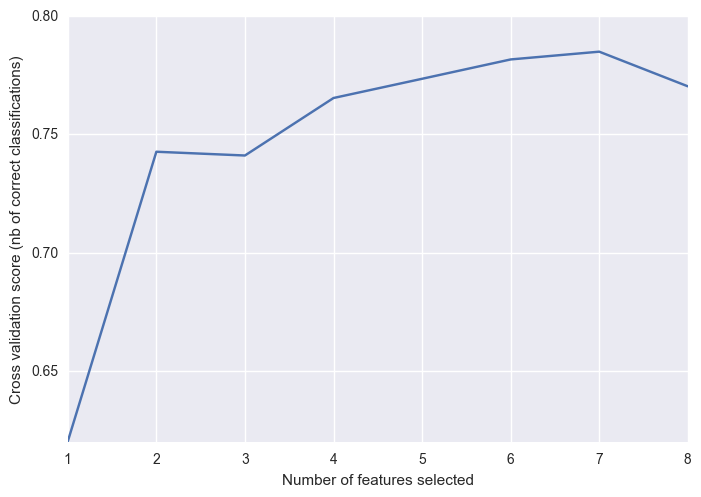

In [10]:

# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=GradientBoostingClassifier(), step=1, cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [11]:
rfecv.ranking_

array([1, 1, 1, 2, 1, 1, 1, 1])

In [12]:
pd.set_option('display.max_rows', None)
df[df['insu'] > 400]['class'].mean()

0.6

The same result is obtained as in the correlation matrix. The 'skin' feature is weakly correlated. Maybe drop it?

In [13]:
clf1 = GradientBoostingClassifier()
clf2 = GaussianNB()
clf3 = AdaBoostClassifier()
clf4 = ExtraTreesClassifier()
eclf = VotingClassifier(estimators=[('grad', clf1), ('gauss', clf2), ('ada', clf3), ('extra', clf4)], voting='hard')

grid = GridSearchCV(estimator=eclf, param_grid=[{}], cv=10)
grid.fit(X_train, y_train)
grid_results_as_df(grid)

,mean,std
0,0.749186,0.031886


xgboost installation instructions:
https://www.ibm.com/developerworks/community/blogs/jfp/entry/Installing_XGBoost_For_Anaconda_on_Windows?lang=en
http://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

In [22]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
print(model.get_params())
model = XGBClassifier()
model.fit(X_train, y_train)
grid = GridSearchCV(estimator=model, param_grid=[{}], cv=10)
grid.fit(X_train, y_train)
grid_results_as_df(grid)

{'colsample_bylevel': 1, 'max_depth': 3, 'silent': True, 'objective': 'binary:logistic', 'gamma': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'max_delta_step': 0, 'colsample_bytree': 1, 'base_score': 0.5, 'learning_rate': 0.1, 'seed': 0, 'nthread': -1, 'missing': None, 'min_child_weight': 1, 'subsample': 1, 'n_estimators': 100}


,mean,std
0,0.767101,0.038752
